Graphs to make:
- [V] 1. Lissajous overview
- [V] 2. Current/Voltage profile overview

Step 0: import libraries and create static variables

In [6]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
from matplotlib.patches import FancyArrowPatch

In [7]:
# Define the alpha value for the post-plasma materials
alpha = 0.65

# Define the color for each material
cb_colors = {
    'γ-Al₂O₃': (0/255, 0/255, 0/255),
    '2% CuO@γ-Al₂O₃': (86/255, 180/255, 233/255),
    '10% CuO@γ-Al₂O₃': (0/255, 114/255, 178/255),
    '2% Fe₂O₃@γ-Al₂O₃': (230/255, 159/255, 0/255),
    '10% Fe₂O₃@γ-Al₂O₃': (213/255, 94/255, 0/255)
}

# determine order of materials for plotting
material_order = [
    'γ-Al₂O₃',
    '2% CuO@γ-Al₂O₃',
    '10% CuO@γ-Al₂O₃',
    '2% Fe₂O₃@γ-Al₂O₃',
    '10% Fe₂O₃@γ-Al₂O₃',
]

t_quantile = stats.t.ppf(1 - 0.05/2, 7)

In [8]:
# Use Times New Roman font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

# Set font size
plt.rcParams['font.size'] = 7

Step 1: import & prepare data

In [63]:
# set the folder and file name
folder_path = r'N:\FWET\FDCH\AdsCatal\General\personal_work_folders\plasmacatdesign\drm\ugent'

In [64]:
file_name = 'ugent_drm_electrical_data_combined.parquet'
file_path = os.path.join(folder_path, file_name)

# read the Excel file
df = pd.read_parquet(file_path)
df.columns

Index(['project_name', 'psdata_file_name', 'measurement_date',
       'measurement_number', 'material_supplier', 'material_name',
       'reaction_type', 'wattage_const', 'residence_time_s', 'plasma_state',
       'cycle', 'power_plasma_W', 'power_plasma_UIprod_W', 'power_source_W',
       'U_pp_V', 'current_rms_reactor_A', 'current_rms_plasma_A',
       'current_rms_source_A', 'U_burning_neg_V', 'U_burning_pos_V',
       'U_burning_avg_V', 'U_breakdown_neg_V', 'U_breakdown_pos_V',
       'U_breakdown_avg_V', 'Q_delta_dis_pos_C', 'Q_delta_dis_neg_C',
       'Q_delta_dis_avg_C', 'avg_num_udisch_per_cycle', 'C_cell_neg_F',
       'C_cell_neg_intrcpt_C', 'C_cell_pos_F', 'C_cell_pos_intrcpt_C',
       'C_cell_avg_F', 'C_diel_eff_neg_F', 'C_diel_eff_neg_intrcpt_C',
       'C_diel_eff_pos_F', 'C_diel_eff_pos_intrcpt_C', 'C_diel_eff_avg_F',
       'alpha_neg', 'alpha_pos', 'alpha_avg', 'beta_neg', 'beta_pos',
       'beta_avg'],
      dtype='object')

In [65]:
# subset the data by selecting only the rows where 'residence_time_s'
# is between 10 and 70 seconds (inclusive)
df = df[
    (df['residence_time_s'] >= 10) &
    (df['residence_time_s'] <= 80) &
    (df['plasma_state'] == 'plasma')
].assign(
    U_pp_kV=lambda x: x['U_pp_V'] / 1000,
    sei_kjmol=lambda x: (x['power_plasma_W'] / 
                         (
                          (1 - 0.4687) *
                          ( 17.31 / x['residence_time_s'])
                         ) * 24.055
                        ),
    Q_delta_dis_avg_nC=lambda x: x['Q_delta_dis_avg_C'] * 1e9,
    current_rms_reactor_mA=lambda x: x['current_rms_reactor_A'] * 1e3,
    U_burning_kV=lambda x: x['U_burning_avg_V'] / 1000,
    sei_ideal_kjmol=lambda x: round(
        number=30/((1-0.4687)*(17.31/x['residence_time_s']))*24.055,
        ndigits=-1
    ).astype(int),
    C_cell_avg_pF=lambda x: x['C_cell_avg_F'] * 1e12
).reset_index(drop=True)

df['material_name'] = df['material_name'].map(
    {
        'sasol-1.8-c450': 'γ-Al₂O₃',
        'sasol-1.8-cuo-02%': '2% CuO@γ-Al₂O₃',
        'sasol-1.8-cuo-10%': '10% CuO@γ-Al₂O₃',
        'sasol-1.8-fe2o3-02%': '2% Fe₂O₃@γ-Al₂O₃',
        'sasol-1.8-fe2o3-10%': '10% Fe₂O₃@γ-Al₂O₃'
    }
)

# Determine for every group of material_name and residence_time_s
# the values for which the measurement_number varialble is largest
# and select only those rows
df = df[
    df.groupby(['material_name', 'residence_time_s'])['measurement_number'].transform("max") == df['measurement_number']
].reset_index(drop=True)

Step 2: U_pp vs SEI

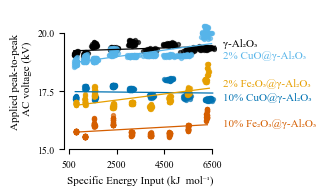

In [12]:
# Create a scatter plot with a linear regression line for each material_name
g = sns.lmplot(
    x="sei_kjmol",
    y="U_pp_kV",
    hue="material_name",
    hue_order=material_order,
    palette=cb_colors,
    data=df,
    height=5/2.54,
    aspect=1.66,
    order=1,
    ci=None,
    legend=False,
    scatter_kws={"s": 8, "alpha": alpha},
    line_kws={"lw": 0.9}
)

g.set_xlabels("Specific Energy Input (kJ  mol⁻¹)", fontsize=8)
g.set_ylabels("Applied peak-to-peak \n AC voltage (kV)", fontsize=8)

ax = g.axes.flatten()[0]

# Define the label points manually
label_points = {
    'γ-Al₂O₃': (6650, 19.4),
    '2% CuO@γ-Al₂O₃': (6650, 18.9),
    '2% Fe₂O₃@γ-Al₂O₃': (6650, 17.7),
    '10% CuO@γ-Al₂O₃': (6650, 17.1),
    '10% Fe₂O₃@γ-Al₂O₃':  (6650, 16.0)
}

# Loop through each item in label_points
# and add a text label with an offset
for material, (x, y) in label_points.items():
    ax.annotate(
        text=material,
        xy=(x, y),
        xytext=(5,0),
        textcoords='offset points',
        fontsize=8,
        color=cb_colors[material]
    )

ax.set_xlim(300, 6650)
ax.spines['bottom'].set_bounds(500, 6500)
ax.set_xticks(ticks=[500, 2500, 4500, 6500])

ax.set_ylim(15, 21)
ax.spines['left'].set_bounds(15, 20)
ax.set_yticks(ticks=[15, 17.5, 20])

plt.tight_layout()
plt.savefig(
    r"C:\Users\sande\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_U_pp_vs_sei.pdf"
)
plt.show()

Step 3: displ Q vs SEI

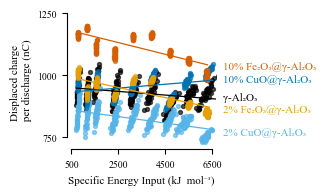

In [13]:
# Create a scatter plot with a linear regression line for each material_name
g = sns.lmplot(
    x="sei_kjmol",
    y="Q_delta_dis_avg_nC",
    hue="material_name",
    hue_order=material_order,
    palette=cb_colors,
    data=df,
    height=5/2.54,
    aspect=1.66,
    order=1,
    ci=None,
    legend=False,
    scatter_kws={"s": 8, "alpha": alpha},
    line_kws={"lw": 0.9}
)

g.set_xlabels("Specific Energy Input (kJ  mol⁻¹)", fontsize=8)
g.set_ylabels("Displaced charge \n per discharge (nC)", fontsize=8)

ax = g.axes.flatten()[0]

# Define the label points manually
label_points = {
    'γ-Al₂O₃': (6650, 900),
    '2% CuO@γ-Al₂O₃': (6650, 756),
    '2% Fe₂O₃@γ-Al₂O₃': (6650, 850),
    '10% CuO@γ-Al₂O₃': (6650, 970),
    '10% Fe₂O₃@γ-Al₂O₃':  (6650, 1025)
}

# Loop through each item in label_points
# and add a text label with an offset
for material, (x, y) in label_points.items():
    ax.annotate(
        text=material,
        xy=(x, y),
        xytext=(5,0),
        textcoords='offset points',
        fontsize=8,
        color=cb_colors[material]
    )

ax.set_xlim(300, 6650)
ax.spines['bottom'].set_bounds(500, 6500)
ax.set_xticks(ticks=[500, 2500, 4500, 6500])

ax.set_ylim(700, 1250)
ax.spines['left'].set_bounds(750, 1250)
ax.set_yticks(ticks=[750, 1000, 1250])

plt.tight_layout()
plt.savefig(
    r"C:\Users\sande\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_displ_Q_vs_sei.pdf"
)
plt.show()

Step 4: RMS reactor I vs SEI

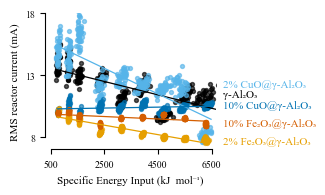

In [14]:
# Create a scatter plot with a linear regression line for each material_name
g = sns.lmplot(
    x="sei_kjmol",
    y="current_rms_reactor_mA",
    hue="material_name",
    hue_order=material_order,
    palette=cb_colors,
    data=df,
    height=5/2.54,
    aspect=1.66,
    order=1,
    ci=None,
    legend=False,
    scatter_kws={"s": 8, "alpha": alpha},
    line_kws={"lw": 0.9}
)

g.set_xlabels("Specific Energy Input (kJ  mol⁻¹)", fontsize=8)
g.set_ylabels("RMS reactor current (mA)", fontsize=8)

ax = g.axes.flatten()[0]

ax.set_xlim(300, 6650)
ax.spines['bottom'].set_bounds(500, 6500)
ax.set_xticks(ticks=[500, 2500, 4500, 6500])

ax.set_ylim(7, 18)
ax.spines['left'].set_bounds(8, 18)
ax.set_yticks(ticks=[8, 13, 18])

# Define the label points manually
label_points = {
    'γ-Al₂O₃': (6650, 11.2),
    '2% CuO@γ-Al₂O₃': (6650, 12),
    '2% Fe₂O₃@γ-Al₂O₃': (6650, 7.4),
    '10% CuO@γ-Al₂O₃': (6650, 10.3),
    '10% Fe₂O₃@γ-Al₂O₃':  (6650, 8.9)
}

# Loop through each item in label_points
# and add a text label with an offset
for material, (x, y) in label_points.items():
    ax.annotate(
        text=material,
        xy=(x, y),
        xytext=(5,0),
        textcoords='offset points',
        fontsize=8,
        color=cb_colors[material]
    )

plt.tight_layout()
plt.savefig(
    r"C:\Users\sande\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_rms_reactor_I_vs_sei.pdf"
)
plt.show()

Step 5: # µ-disch vs SEI

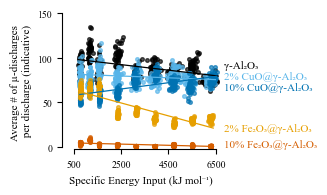

In [15]:
# Create a scatter plot with a linear regression line for each material_name
g = sns.lmplot(
    x="sei_kjmol",
    y="avg_num_udisch_per_cycle",
    hue="material_name",
    hue_order=material_order,
    palette=cb_colors,
    data=df,
    height=5/2.54,
    aspect=1.66,
    order=1,
    ci=None,
    legend=False,
    scatter_kws={"s": 7, "alpha": alpha},
    line_kws={"lw": 0.9}
)

g.set_xlabels("Specific Energy Input (kJ mol⁻¹)", fontsize=8)
g.set_ylabels("Average # of µ-discharges \n per discharge (indicative)", fontsize=8)

ax = g.axes.flatten()[0]

ax.set_xlim(0, 6650)
ax.spines['bottom'].set_bounds(500, 6500)
ax.set_xticks(ticks=[500, 2500, 4500, 6500])

ax.set_ylim(-3, 150)
ax.spines['left'].set_bounds(0, 150)
ax.set_yticks(ticks=[0, 50, 100, 150])

# Define the label points manually
label_points = {
    'γ-Al₂O₃': (6550, 88),
    '2% CuO@γ-Al₂O₃': (6550, 76),
    '2% Fe₂O₃@γ-Al₂O₃': (6550, 18),
    '10% CuO@γ-Al₂O₃': (6550, 64),
    '10% Fe₂O₃@γ-Al₂O₃':  (6550, 0)
}

# Loop through each item in label_points
# and add a text label with an offset
for material, (x, y) in label_points.items():
    ax.annotate(
        text=material,
        xy=(x, y),
        xytext=(5,0),
        textcoords='offset points',
        fontsize=8,
        color=cb_colors[material]
    )

plt.tight_layout()
plt.savefig(
    r"C:\Users\sande\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_num_udisch_vs_sei.pdf"
)
plt.show()

Step 6: IU profile overview

In [16]:
# Step 1: load the data
file_name = 'ugent_drm_profile_data_combined.parquet'
file_path = os.path.join(folder_path, file_name)

# read the .parquet file
df_current_voltage = pd.read_parquet(file_path)

In [17]:
# Step 2: prepare the data
df_current_voltage = df_current_voltage[
    (df_current_voltage['residence_time_s'] >= 10) &
    (df_current_voltage['residence_time_s'] <= 80) &
    (df_current_voltage['plasma_state'] == 'plasma')
].assign(
    voltage_kV=lambda x: x['voltage_V'] / 1e3,
    charge_nC=lambda x: x['charge_C'] * 1e9,
    time_us=lambda x: x['time_s'] * 1e6,
    current_plasma_mA=lambda x: x['current_plasma_A'] * 1e3,
    sei_ideal_kjmol=lambda x: round(
        number=30/((1-0.4687)*(17.31/x['residence_time_s']))*24.055,
        ndigits=-1
    ).astype(int)
).reset_index(drop=True)

df_current_voltage['material_name'] = df_current_voltage['material_name'].map(
    {
        'sasol-1.8-c450': 'γ-Al₂O₃',
        'sasol-1.8-cuo-02%': '2% CuO@γ-Al₂O₃',
        'sasol-1.8-cuo-10%': '10% CuO@γ-Al₂O₃',
        'sasol-1.8-fe2o3-02%': '2% Fe₂O₃@γ-Al₂O₃',
        'sasol-1.8-fe2o3-10%': '10% Fe₂O₃@γ-Al₂O₃'
    }
)

# Determine for every group of material_name and sei_ideal_kjmol
# the values for which the measurement_number variable is largest
# and select only those rows
df_current_voltage_filtered = df_current_voltage[
    df_current_voltage.groupby(
        ['material_name', 'sei_ideal_kjmol']
    )['measurement_number'].transform("max") == df_current_voltage['measurement_number']
].reset_index(drop=True).copy()

# Select for every group of material_name and sei_ideal_kjmol
# a random psdata_file_name and select only those rows

# Step 1: Generate a random psdata_file_name for each group
# Create a DataFrame with a random psdata_file_name for each combination of material_name and sei_ideal_kjmol
def random_psdata(group):
    return pd.Series({
        'random_psdata_file_name': np.random.choice(group['psdata_file_name'])
    })

random_psdata_mappings = df_current_voltage_filtered.groupby(['material_name', 'sei_ideal_kjmol']).apply(random_psdata, include_groups=False).reset_index()

# Step 2: Merge this random selection back to the original DataFrame
# This filters for rows where the psdata_file_name matches the randomly selected psdata_file_name for each group
# Merge the random psdata_file_name selection with the original DataFrame
df_final_filtered = pd.merge(
    df_current_voltage_filtered,
    random_psdata_mappings,
    on=['material_name', 'sei_ideal_kjmol'],
    how='inner'
)

# Filter rows to match the randomly selected psdata_file_name
df_final_filtered = df_final_filtered[df_final_filtered['psdata_file_name'] == df_final_filtered['random_psdata_file_name']]

# Optionally, drop the 'random_psdata_file_name' column as it's no longer needed
df_final_filtered.drop(columns=['random_psdata_file_name'], inplace=True)

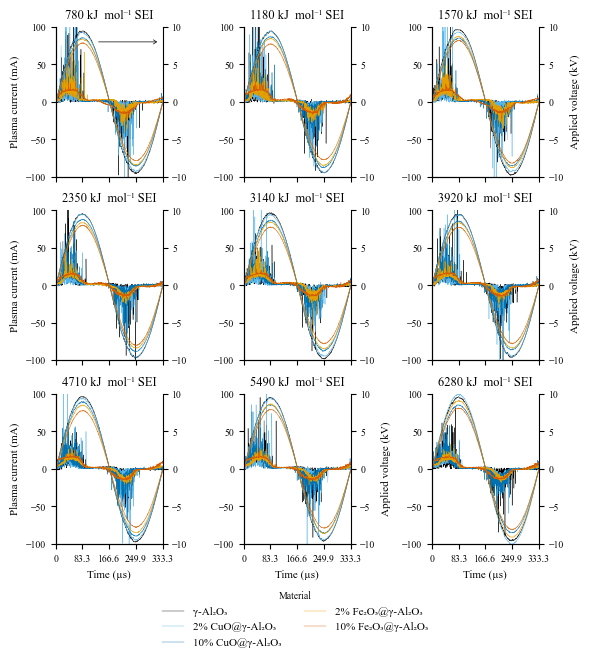

In [18]:
g = sns.relplot(
    data=df_final_filtered,
    x='time_us',
    y='current_plasma_mA',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    kind='line',
    col='sei_ideal_kjmol',
    col_wrap=3,
    height=5/2.54,
    aspect=1,
    legend=True,
    facet_kws={'legend_out': False},
    linewidth=0.285,
    estimator=None
)

# set the x-axis limits
g.set(xlim=(0, 333))

# Set specific x-axis ticks
for ax in g.axes.flatten():
    ax.set_xticks([0, 83.33, 166.66, 249.99, 333.33])
    ax.set_xticklabels(['0', '83.3', '166.6', '249.9', '333.3'])

# set the y-axis limits
g.set(ylim=(-100, 100))

# set titles and labels
g.set_titles(col_template="{col_name} kJ  mol⁻¹ SEI", size=9)
g.set_xlabels("Time (µs)", size=8)
g.set_ylabels("Plasma current (mA)", size=8)

# Define a list of subplot indices that should have the custom y-axis label
label_indices = [2, 5, 7]  # 0-based indexing for 3rd, 6th, and 8th plots

# Iterate over each subplot in the FacetGrid to add a second y-axis
for i, (ax, (name, group)) in enumerate(zip(g.axes.flat, df_final_filtered.groupby('sei_ideal_kjmol'))):
    # Create a twin y-axis for the current subplot
    ax2 = ax.twinx()
    
    # Plot your second variable ('voltage_kV') on the twin y-axis
    # Note: You will need to filter 'group' for the specific subplot based on 'residence_time_s' and possibly other conditions
    sns.lineplot(
        data=group,
        x='time_us',
        y='voltage_kV',
        ax=ax2,
        hue='material_name',
        hue_order=material_order,
        palette=cb_colors,
        legend=False,
        linewidth=0.45,
        alpha=0.8
    )
    
    # Set the label for the twin y-axis based on the current subplot index
    if i in label_indices:
        ax2.set_ylabel("Applied voltage (kV)", fontsize=8)
    else:
        ax2.set_ylabel("", fontsize=8)
    
    # Adjust the twin y-axis tick parameters
    ax2.set_ylim(-10, 10)
    ax2.tick_params(axis='y', labelsize=7)
    
    sns.despine(ax=ax2, top=True, right=False, left=False, bottom=False)
    
    # Ensure the twin y-axis does not interfere with the layout
    ax.figure.tight_layout()

ax1 = g.axes.flatten()[0]

arrow = FancyArrowPatch((125, 80), (325, 80),
                        arrowstyle='->,head_width=1.5,head_length=2.25',
                        color='black',
                        lw=0.5)

# Add the arrow to the plot
ax1.add_patch(arrow)

sns.move_legend(
    g,
    loc='lower center',
    title='Material',
    bbox_to_anchor=(0.5, -0.115),
    frameon=False,
    fontsize=8,
    ncols=2
)

plt.savefig(
    r"C:\Users\sande\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_IU_profile_overview.pdf",
    bbox_inches='tight'
)
plt.show()

Step 6.1: IU profile at 3140 kJ/mol SEI

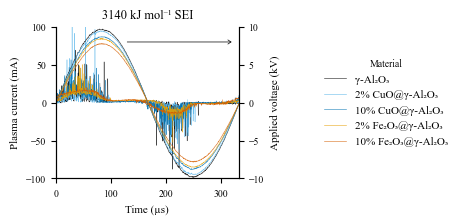

In [19]:
# Filter the DataFrame for sei_ideal_kjmol equals 3140
filtered_df = df_final_filtered[df_final_filtered['sei_ideal_kjmol'] == 3140]

# Create the plot
fig, ax1 = plt.subplots(figsize=(6/2.54, 5/2.54))

sns.lineplot(
    data=filtered_df,
    x='time_us',
    y='current_plasma_mA',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    ax=ax1,
    linewidth=0.285,
    legend=False,
    alpha=0.9
)

# Set the x-axis and y-axis limits
ax1.set_xlim(0, 333)
ax1.set_ylim(-100, 100)

# Set titles and labels
ax1.set_title("3140 kJ mol⁻¹ SEI", fontsize=9)
ax1.set_xlabel("Time (µs)", fontsize=8)
ax1.set_ylabel("Plasma current (mA)", fontsize=8)

# Create a twin y-axis
ax2 = ax1.twinx()

# Plot voltage on the twin y-axis
sns.lineplot(
    data=filtered_df,
    x='time_us',
    y='voltage_kV',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    ax=ax2,
    linewidth=0.45,
    legend=True,
    alpha=0.8
)

# Set the twin y-axis label and limits
ax2.set_ylabel("Applied voltage (kV)", fontsize=8)
ax2.set_ylim(-10, 10)
ax2.tick_params(axis='y', labelsize=7)

# Despine axes
sns.despine(ax=ax1, top=True, right=False, left=False, bottom=False)
sns.despine(ax=ax2, top=True, right=False, left=False, bottom=False)

# Add an arrow
arrow = FancyArrowPatch((125, 80), (325, 80),
                        arrowstyle='->,head_width=1.5,head_length=2.25',
                        color='black',
                        lw=0.5)
ax1.add_patch(arrow)

# Move legend to the lower right
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(
    handles,
    labels,
    loc='center right',
    title='Material',
    fontsize=8,
    frameon=False,
    bbox_to_anchor=(2.2, 0.50)
)

# Save the plot
plt.savefig(
    r"C:\Users\sande\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_IU_profile_40s.pdf",
    bbox_inches='tight'
)

# Show the plot
plt.show()

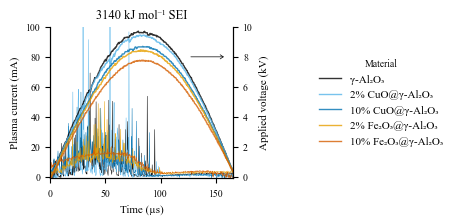

In [20]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(6/2.54, 5/2.54))

sns.lineplot(
    data=filtered_df,
    x='time_us',
    y='current_plasma_mA',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    ax=ax1,
    linewidth=0.385,
    legend=False,
    alpha=0.9
)

# Set the x-axis and y-axis limits
ax1.set_xlim(0, 166)
ax1.set_ylim(-1, 100)

# Set titles and labels
ax1.set_title("3140 kJ mol⁻¹ SEI", fontsize=9)
ax1.set_xlabel("Time (µs)", fontsize=8)
ax1.set_ylabel("Plasma current (mA)", fontsize=8)

# Create a twin y-axis
ax2 = ax1.twinx()

# Plot voltage on the twin y-axis
sns.lineplot(
    data=filtered_df,
    x='time_us',
    y='voltage_kV',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    ax=ax2,
    linewidth=1,
    legend=True,
    alpha=0.8
)

# Set the twin y-axis label and limits
ax2.set_ylabel("Applied voltage (kV)", fontsize=8)
ax2.set_ylim(-0.1, 10)
ax2.tick_params(axis='y', labelsize=7)

# Despine axes
sns.despine(ax=ax1, top=True, right=False, left=False, bottom=False)
sns.despine(ax=ax2, top=True, right=False, left=False, bottom=False)

# Add an arrow
arrow = FancyArrowPatch((125, 80), (160, 80),
                        arrowstyle='->,head_width=1.5,head_length=2.25',
                        color='black',
                        lw=0.5)
ax1.add_patch(arrow)

# Move legend to the lower right
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(
    handles,
    labels,
    loc='center right',
    title='Material',
    fontsize=8,
    frameon=False,
    bbox_to_anchor=(2.2, 0.50)
)

# Save the plot
plt.savefig(
    r"C:\Users\sande\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_IU_profile_half_40s.pdf",
    bbox_inches='tight'
)

# Show the plot
plt.show()

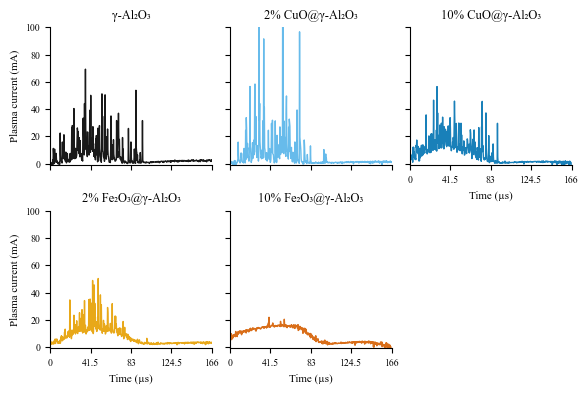

In [21]:
g = sns.relplot(
    data=filtered_df,
    kind='line',
    x='time_us',
    y='current_plasma_mA',
    col='material_name',
    col_wrap=3,
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=5/2.54,
    aspect=1,
    legend=False,
    linewidth=1,
    alpha=0.9
)

g.set(xlim=(0, 166))
g.set(ylim=(-1, 100))
g.set_xlabels("Time (µs)", fontsize=8)
g.set_ylabels("Plasma current (mA)", fontsize=8)
g.set_titles(col_template="{col_name}", size=9)

for ax in g.axes.flatten():
    ax.set_xticks([0, 41.5, 83, 124.5, 166])
    ax.set_xticklabels(['0', '41.5', '83', '124.5', '166'])

plt.savefig(
    r"C:\Users\sande\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_profile_half_spread.pdf",
    bbox_inches='tight'
)

plt.show()

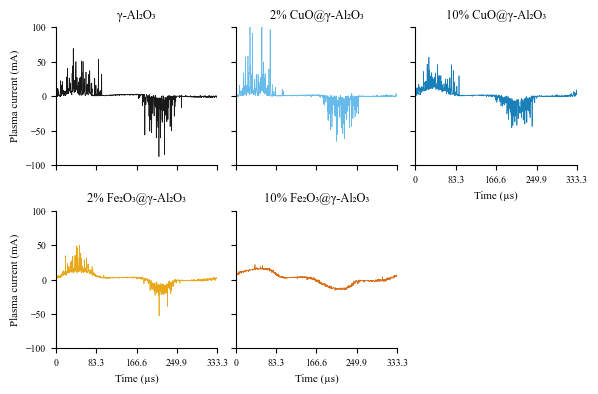

In [22]:
g = sns.relplot(
    data=filtered_df,
    kind='line',
    x='time_us',
    y='current_plasma_mA',
    col='material_name',
    col_wrap=3,
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=5/2.54,
    aspect=1,
    legend=False,
    linewidth=0.5,
    alpha=0.9
)

g.set(xlim=(0, 333))
g.set(ylim=(-100, 100))
g.set_xlabels("Time (µs)", fontsize=8)
g.set_ylabels("Plasma current (mA)", fontsize=8)
g.set_titles(col_template="{col_name}", size=9)

for ax in g.axes.flatten():
    ax.set_xticks([0, 83.3, 166.6, 249.9, 333.3])
    ax.set_xticklabels(['0', '83.3', '166.6', '249.9', '333.3'])

plt.savefig(
    r"C:\Users\sande\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_profile_spread.pdf",
    bbox_inches='tight'
)

plt.show()

Step 7: Lissajous overview

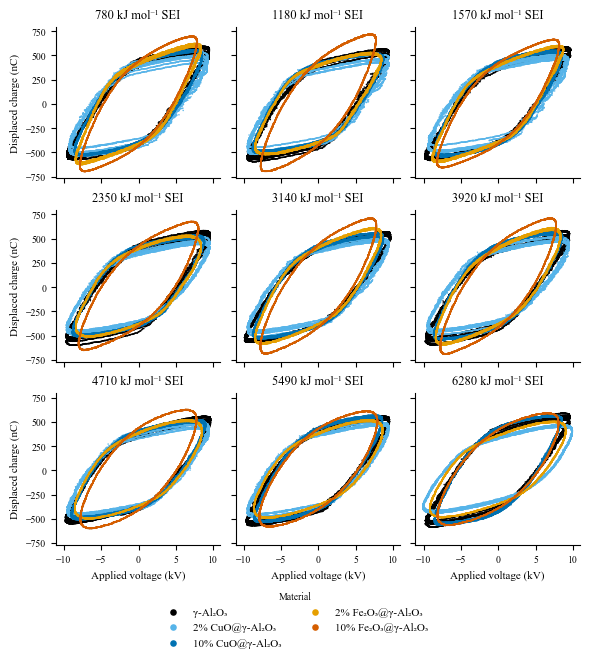

In [23]:
g = sns.relplot(
    data=df_final_filtered,
    x='voltage_kV',
    y='charge_nC',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    kind='scatter',
    col='sei_ideal_kjmol',
    col_wrap=3,
    height=5/2.54,
    aspect=1,
    s=0.9,
    legend=True,
    facet_kws={'legend_out': False},
    edgecolor = None
)

sns.move_legend(
    g,
    loc='lower center',
    title='Material',
    bbox_to_anchor=(0.5, -0.115),
    frameon=False,
    fontsize=8,
    markerscale=5,
    ncols=2
)

g.set_titles(col_template="{col_name} kJ mol⁻¹ SEI", size=9)
g.set_xlabels("Applied voltage (kV)", size=8)
g.set_ylabels("Displaced charge (nC)", size=8)

plt.savefig(
    r"C:\Users\sande\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_lissajous_overview.pdf",
    bbox_inches='tight'
)
plt.show()

Step 7.1: Lissajous at 3140 kJ/mol SEI

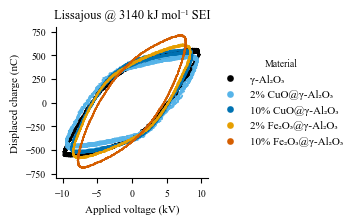

In [24]:
# Set up the figure size and plot directly with seaborn
plt.figure(figsize=(5/2.54, 5/2.54))  # Size adjustments as needed

sns.scatterplot(
    data=filtered_df,
    x='voltage_kV',
    y='charge_nC',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    legend=True,
    alpha=1,
    edgecolor=None,
    s=0.9
)

# Customize plot limits, titles, and labels directly
plt.xlim(-11, 11)
plt.ylim(-800, 800)
plt.title("Lissajous @ 3140 kJ mol⁻¹ SEI", fontsize=9)
plt.xlabel("Applied voltage (kV)", fontsize=8)
plt.ylabel("Displaced charge (nC)", fontsize=8)

# Move and style the legend using plt
plt.legend(
    loc='center right',
    title='Material',
    bbox_to_anchor=(1.95, 0.50),
    frameon=False,
    fontsize=8,
    markerscale=5
)

# Remove extra borders with sns.despine
sns.despine(top=True, right=True, left=False, bottom=False)

# Save and display the plot
plt.savefig(
    r"C:\Users\sande\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_lissajous_40s.pdf",
    bbox_inches='tight'
)
plt.show()

Step 8: lissajous x current-voltage

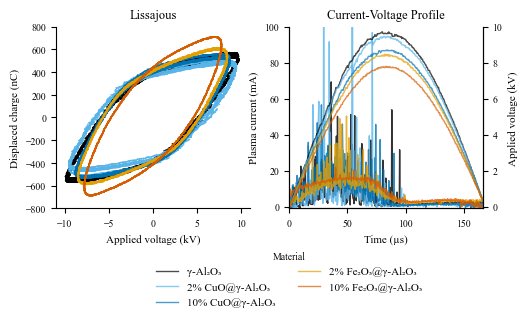

In [25]:
# Set up the figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14/2.54, 6/2.54))

# Plot the left scatter plot
sns.scatterplot(
    data=filtered_df,
    x='voltage_kV',
    y='charge_nC',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    alpha=1,
    edgecolor=None,
    s=0.9,
    ax=ax1,
    legend=False
)
ax1.set_xlim(-11, 11)
ax1.set_ylim(-800, 800)
ax1.set_title("Lissajous", fontsize=9)
ax1.set_xlabel("Applied voltage (kV)", fontsize=8)
ax1.set_ylabel("Displaced charge (nC)", fontsize=8)
sns.despine(ax=ax1, top=True, right=True, left=False, bottom=False)

# Plot the right line plot
sns.lineplot(
    data=filtered_df,
    x='time_us',
    y='current_plasma_mA',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    linewidth=1,
    alpha=0.8,
    ax=ax2,
    legend=False
)
ax2.set_xlim(0, 166)
ax2.set_ylim(-1, 100)
ax2.set_title("Current-Voltage Profile", fontsize=9)
ax2.set_xlabel("Time (µs)", fontsize=8)
ax2.set_ylabel("Plasma current (mA)", fontsize=8)
sns.despine(ax=ax2, top=True, right=False, left=False, bottom=False)

# Create a twin y-axis on the second plot
ax2_twin = ax2.twinx()
sns.lineplot(
    data=filtered_df,
    x='time_us',
    y='voltage_kV',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    linewidth=1,
    alpha=0.7,
    ax=ax2_twin,
    legend=True
)
ax2_twin.set_ylabel("Applied voltage (kV)", fontsize=8)
ax2_twin.set_ylim(-0.1, 10)
sns.despine(ax=ax2_twin, top=True, right=False, left=False, bottom=False)

# Set up the legend for the entire figure below both plots
sns.move_legend(
    ax2_twin,
    loc='lower center',
    title='Material',
    bbox_to_anchor=(0, -0.6),
    frameon=False,
    fontsize=8,
    ncol=2
)

plt.savefig(
    r"C:\Users\sande\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_lissajous_profile_combo.pdf",
    bbox_inches='tight'
)

# Show the plot
plt.show()

Step 9: beta_avg vs U_burning_kV

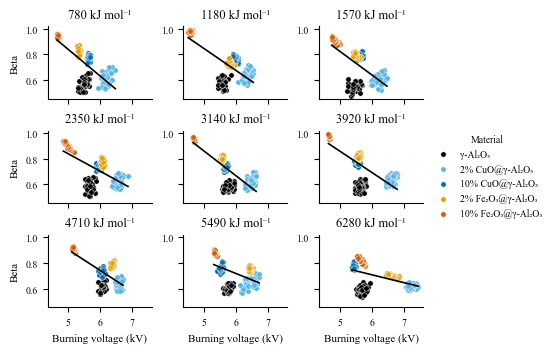

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df,
    col='sei_ideal_kjmol',
    col_wrap=3,
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=3/2.54,
    aspect=1.25
)

g.map(
    sns.scatterplot,
    'U_burning_kV',
    'beta_avg',
    s=15
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df.groupby('sei_ideal_kjmol', sort=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='U_burning_kV',
        y='beta_avg',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(col_template="{col_name} kJ mol⁻¹", size=9)
g.set_axis_labels(
    x_var="Burning voltage (kV)",
    y_var="Beta",
    size=8
)

plt.savefig(
    r"C:\Users\sande\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_beta_vs_U_burning_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 10: Q_delta_dis_vs_U_burning_per_sei

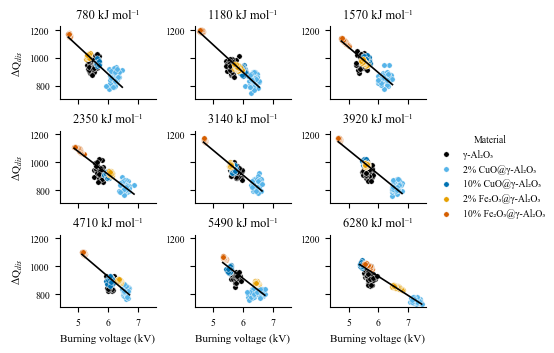

In [61]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df,
    col='sei_ideal_kjmol',
    col_wrap=3,
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=3/2.54,
    aspect=1.25
)

g.map(
    sns.scatterplot,
    'U_burning_kV',
    'Q_delta_dis_avg_nC',
    s=15
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df.groupby('sei_ideal_kjmol', sort=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='U_burning_kV',
        y='Q_delta_dis_avg_nC',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(col_template="{col_name} kJ mol⁻¹", size=9)
g.set_axis_labels(
    x_var="Burning voltage (kV)",
    y_var="ΔQ$_{dis}$",
    size=8
)

plt.savefig(
    r"C:\Users\sande\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_Q_delta_dis_vs_U_burning_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 11:

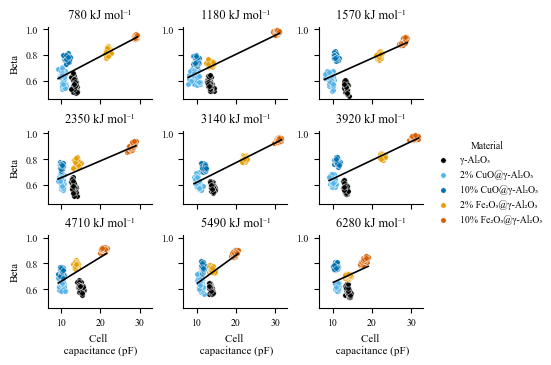

In [68]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df,
    col='sei_ideal_kjmol',
    col_wrap=3,
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=3/2.54,
    aspect=1.25
)

g.map(
    sns.scatterplot,
    'C_cell_avg_pF',
    'beta_avg',
    s=15
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df.groupby('sei_ideal_kjmol', sort=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='C_cell_avg_pF',
        y='beta_avg',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(col_template="{col_name} kJ mol⁻¹", size=9)
g.set_axis_labels(
    x_var="Cell \n capacitance (pF)",
    y_var="Beta",
    size=8
)

plt.savefig(
    r"C:\Users\sande\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_beta_vs_C_cell_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

In [ ]:
#%reset -f